In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder ,MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LinearRegression,SGDClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier




In [97]:
# Load the dataset thats gonna be used
file_path = './Assignment2/official_clean_data.csv'
housing_data = pd.read_csv(file_path)

In [5]:
#Function to categorize the price 
def categorize_price(price):
    if price < 1000000:
        return 'green'
    elif 1000000 <= price < 2000000:
        return 'orange'
    else:
        return 'red'

**RANDOM FOREST WITH MINMAXING. Doing testing on two different versions to see what the effects of min max scalar would be on the models accuracy.**

In [31]:

housing_data['Price_Category'] = housing_data['Price_winsorized'].apply(categorize_price)

# Prepare the data for Random Forest classification
# Select features for the model (excluding irrelevant ones like Address)
features = ['Rooms', 'Distance from CBD', 'Bedroom2', 'Bathroom', 
            'Landsize_winsorized', 'Propertycount', 'PricePerSquareMeter', 
            'Average_Criminial_Incidents_Rate', 'Average_Victimisation_Rate']

# Encode categorical features
categorical_features = ['Suburb', 'Type', 'Method', 'CouncilArea', 'Regionname']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    housing_data[feature] = le.fit_transform(housing_data[feature])
    label_encoders[feature] = le
    features.append(feature)

# Target variable
target = 'Price_Category'

# Drop rows with missing values
housing_data_cleaned = housing_data.dropna()

# Split the cleaned data into training and testing sets
X_cleaned = housing_data_cleaned[features]
y_cleaned = housing_data_cleaned[target]

# Split data into training and test sets
X_train_cleaned, X_test_cleaned, y_train_cleaned, y_test_cleaned = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=42)

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_test_scaled = scaler.transform(X_test_cleaned)

# Train the Random Forest classifier on the scaled data
rf_classifier_scaled = RandomForestClassifier(random_state=42)
rf_classifier_scaled.fit(X_train_scaled, y_train_cleaned)

# Make predictions on the test data
y_pred_scaled = rf_classifier_scaled.predict(X_test_scaled)

# Evaluate the model
accuracy_scaled = accuracy_score(y_test_cleaned, y_pred_scaled)
classification_report_scaled = classification_report(y_test_cleaned, y_pred_scaled)

# Print results
print(f"Accuracy after scaling: {accuracy_scaled * 100 :.2f}%")
print("Classification Report after scaling:")
print(classification_report_scaled)

Accuracy after scaling: 91.11%
Classification Report after scaling:
              precision    recall  f1-score   support

       green       0.94      0.95      0.95      1812
      orange       0.86      0.89      0.88      1160
         red       0.90      0.73      0.81       280

    accuracy                           0.91      3252
   macro avg       0.90      0.86      0.88      3252
weighted avg       0.91      0.91      0.91      3252



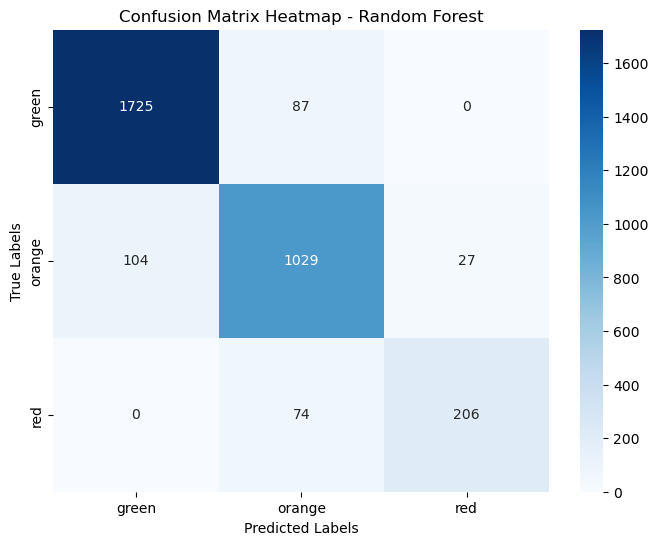

In [82]:

conf_matrix = confusion_matrix(y_test_cleaned, y_pred_cleaned)

# Plot the heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['green', 'orange', 'red'], 
            yticklabels=['green', 'orange', 'red'])
plt.title('Confusion Matrix Heatmap - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [35]:
#Cross validation score on RF with 
cv_scores = cross_val_score(rf_classifier_cleaned, X_cleaned, y_cleaned, cv=5)
print(f"Cross-validation accuracy scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean()}")

Cross-validation accuracy scores: [0.89298893 0.87453875 0.87361624 0.89068266 0.90678357]
Mean cross-validation accuracy: 0.8877220280047748


In [76]:
#Using SMOTE to fix the over sampling of data.  Tested without smote and its a 4% increase in performance
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cleaned, y_train_cleaned)

svm_classifier_smote = SVC(kernel='rbf', random_state=42)

svm_classifier_smote.fit(X_train_resampled, y_train_resampled)

y_pred_svm_smote = svm_classifier_smote.predict(X_test_cleaned)

accuracy_svm_smote = accuracy_score(y_test_cleaned, y_pred_svm_smote)
classification_report_svm_smote = classification_report(y_test_cleaned, y_pred_svm_smote, zero_division=1)

print(f"Accuracy after SMOTE: {accuracy_svm_smote * 100 :.2f}%")
print("Classification Report (after SMOTE):")
print(classification_report_svm_smote)

Accuracy after SMOTE: 76.01%
Classification Report (after SMOTE):
              precision    recall  f1-score   support

       green       0.90      0.77      0.83      1812
      orange       0.69      0.70      0.70      1160
         red       0.49      0.94      0.64       280

    accuracy                           0.76      3252
   macro avg       0.70      0.80      0.72      3252
weighted avg       0.79      0.76      0.77      3252



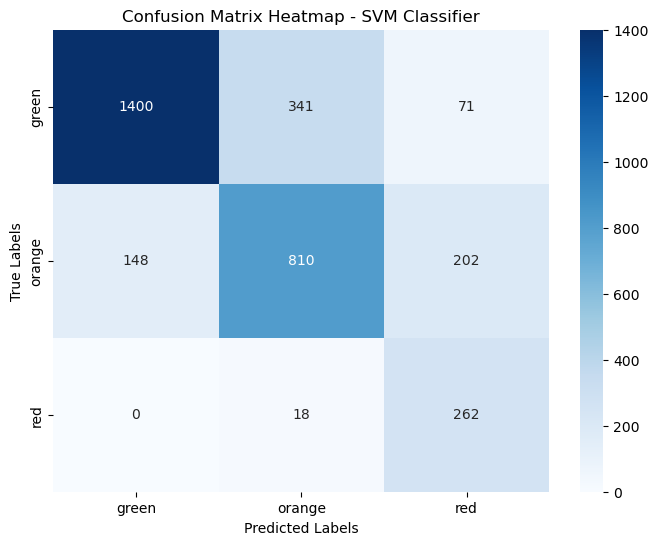

In [84]:
conf_matrix_svm_smote = confusion_matrix(y_test_cleaned, y_pred_svm_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm_smote, annot=True, fmt='d', cmap='Blues', xticklabels=svm_classifier_smote.classes_, yticklabels=svm_classifier_smote.classes_)
plt.title('Confusion Matrix Heatmap - SVM Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [86]:
# Cross-validation scores for SVM Classifier
cross_val_scores_svm_smote = cross_val_score(svm_classifier_smote, X_train_resampled, y_train_resampled, cv=5)

print("Cross-validation scores (after SMOTE):")
print(cross_val_scores_svm_smote)
print(f"Mean cross-validation accuracy: {cross_val_scores_svm_smote.mean() * 100:.2f}%")

Cross-validation scores (after SMOTE):
[0.77958053 0.78749505 0.77720617 0.77276326 0.77711797]
Mean cross-validation accuracy: 77.88%


In [72]:

# Split the cleaned data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_cleaned, housing_data_cleaned['Price_winsorized'], test_size=0.3, random_state=42)

rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)
rf_regressor.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_regressor.predict(X_test_reg)

# use mean squared error on the model and R2 score to test accuracy
mse_rf = mean_squared_error(y_test_reg, y_pred_rf)
r2_rf = r2_score(y_test_reg, y_pred_rf)
print(f"Random Forest Regressor - Mean Squared Error: {mse_rf:.2f}, R2 Score: {r2_rf:.2f}")


Random Forest Regressor - Mean Squared Error: 1719561186.17, R2 Score: 1.00


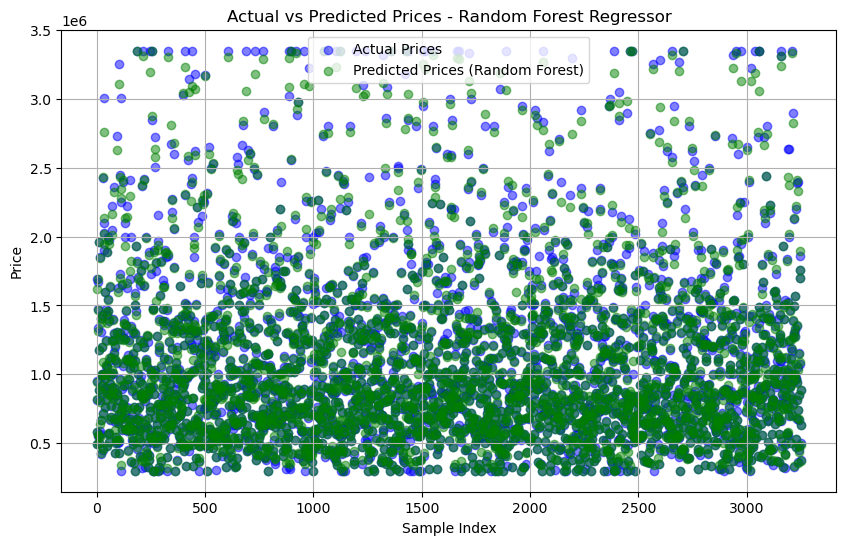

In [91]:
# Plotting Actual vs Predicted Prices for Random Forest Regressor
#The scatter plot shows the actual prices from the dataset vs the predicted prices from the regression model.
#The closer the dots are the more accurate the prediction
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_reg)), y_test_reg, color='blue', alpha=0.5, label='Actual Prices')
plt.scatter(range(len(y_pred_rf)), y_pred_rf, color='green', alpha=0.5, label='Predicted Prices (Random Forest)')
plt.title('Actual vs Predicted Prices - Random Forest Regressor')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

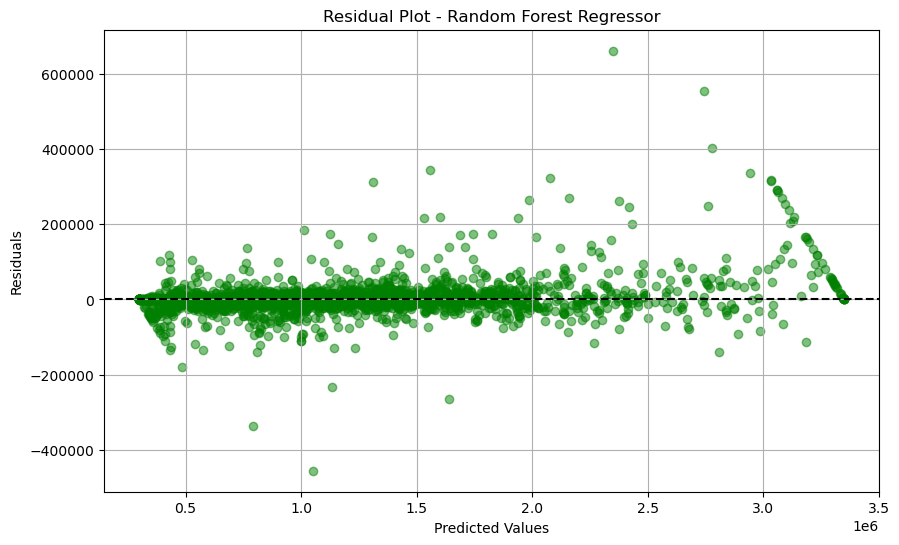

In [70]:
# Residual Plot for Random Forest Regressor
#plot tells you the furthur away from the 0 the less accurate the model is.
#can see here the model is actually decently accurate with some really far reaches but majority is accurate
residuals_rf = y_test_reg - y_pred_rf
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf, residuals_rf, color='green', alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residual Plot - Random Forest Regressor')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()